<a href="https://colab.research.google.com/github/fereidoon27/sample-colab/blob/main/Colabfold_2LHG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
start_time = time.time()

In [2]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random
import pickle  # Add import for pickle

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'TTYKLILNLKQAKEEAIKELVDAGIAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE' #@param {type:"string"}
jobname = 'test' #@param {type:"string"}
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
template_mode = "none" #@param ["none", "pdb100","custom"]

use_amber = num_relax > 0

query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

os.makedirs(jobname, exist_ok=True)

queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname test_f944f
sequence TTYKLILNLKQAKEEAIKELVDAGIAEKYFKLIANAKTVEGVWTYKDEIKTFTVTE
length 56


In [3]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 202 ms, sys: 24.9 ms, total: 227 ms
Wall time: 57.4 s


In [4]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}

# Ensure consistent parameters for MSA generation
msa_generation_params = {
    'msa_mode': msa_mode,
    'pair_mode': pair_mode,
    'database': "uniref_env",  # Specify the database consistently
    'cutoff': 0.8,  # Example cutoff value for sequence inclusion, adjust as needed
    'max_sequences': 15000  # Set a maximum number of sequences for consistency
}

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

# Include additional MSA generation parameters here
def generate_msa(jobname, sequence, msa_generation_params):
    # Custom function to generate MSA using consistent parameters
    # Example implementation:
    os.system(f"some_msa_generation_tool --msa_mode {msa_generation_params['msa_mode']} "
              f"--pair_mode {msa_generation_params['pair_mode']} --database {msa_generation_params['database']} "
              f"--cutoff {msa_generation_params['cutoff']} --max_sequences {msa_generation_params['max_sequences']} "
              f"--output {jobname}/{jobname}.a3m")

# Generate MSA with consistent parameters
generate_msa(jobname, query_sequence, msa_generation_params)

In [5]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"]
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}

max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
dpi = 200 #@param {type:"integer"}

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2024-07-02 09:22:54,522 Running on GPU
2024-07-02 09:22:54,787 Found 5 citations for tools or databases
2024-07-02 09:22:54,787 Query 1/1: test_f944f (length 56)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


2024-07-02 09:22:57,318 Setting max_seq=402, max_extra_seq=1
2024-07-02 09:23:28,352 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=59.2 pTM=0.358
2024-07-02 09:23:35,077 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=57.9 pTM=0.353 tol=1.21
2024-07-02 09:23:41,825 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=60.1 pTM=0.387 tol=0.738
2024-07-02 09:23:48,592 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=64.6 pTM=0.408 tol=0.687
2024-07-02 09:23:48,593 alphafold2_ptm_model_1_seed_000 took 39.9s (3 recycles)


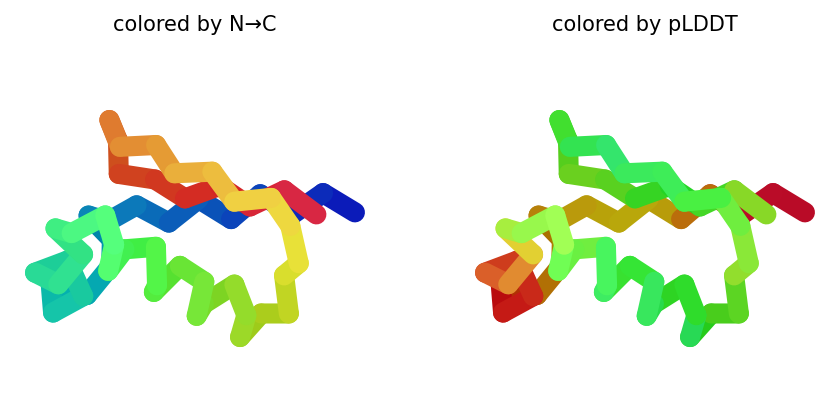

2024-07-02 09:23:55,601 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=55.5 pTM=0.298
2024-07-02 09:24:02,374 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=55 pTM=0.327 tol=9.8
2024-07-02 09:24:09,268 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=60.5 pTM=0.371 tol=1.72
2024-07-02 09:24:16,097 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=61.1 pTM=0.374 tol=0.325
2024-07-02 09:24:16,098 alphafold2_ptm_model_2_seed_000 took 27.4s (3 recycles)


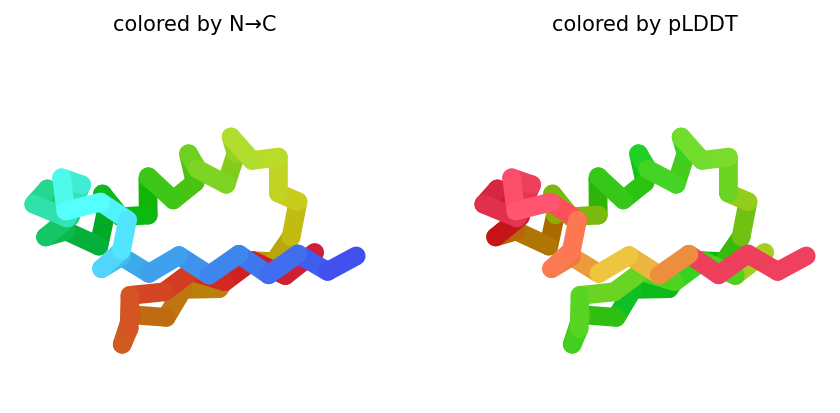

2024-07-02 09:24:23,166 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=49.8 pTM=0.262
2024-07-02 09:24:30,002 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=68.3 pTM=0.427 tol=5.73
2024-07-02 09:24:36,860 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=62.4 pTM=0.364 tol=0.867
2024-07-02 09:24:43,707 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=60.9 pTM=0.364 tol=4.35
2024-07-02 09:24:43,709 alphafold2_ptm_model_3_seed_000 took 27.5s (3 recycles)


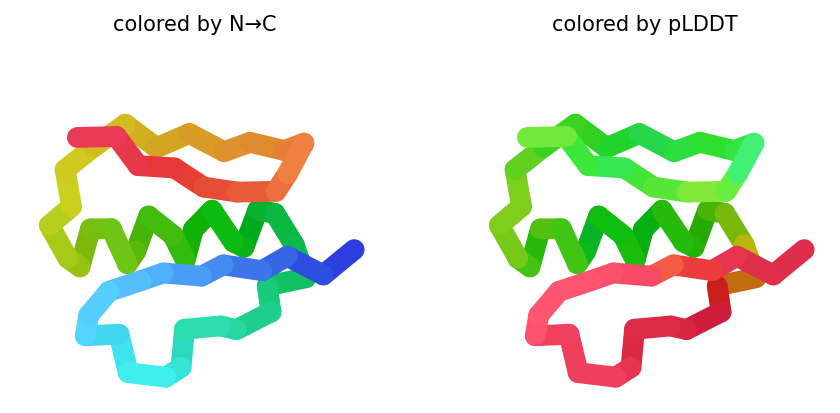

2024-07-02 09:24:50,739 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=75.9 pTM=0.561
2024-07-02 09:24:57,600 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=74.1 pTM=0.543 tol=2.76
2024-07-02 09:25:04,357 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=74.6 pTM=0.557 tol=0.352
2024-07-02 09:25:11,208 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=74.4 pTM=0.552 tol=0.788
2024-07-02 09:25:11,209 alphafold2_ptm_model_4_seed_000 took 27.3s (3 recycles)


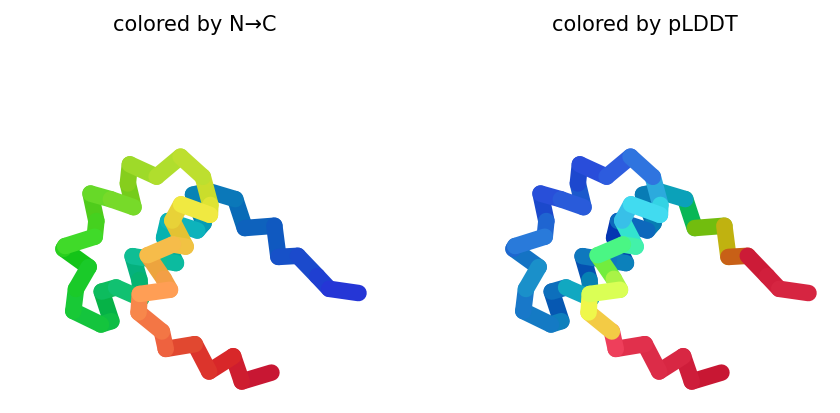

2024-07-02 09:25:18,128 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=62.5 pTM=0.416
2024-07-02 09:25:25,021 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=91.2 pTM=0.707 tol=5.8
2024-07-02 09:25:31,849 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=93.6 pTM=0.729 tol=0.199
2024-07-02 09:25:38,703 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=95.1 pTM=0.752 tol=0.0662
2024-07-02 09:25:38,704 alphafold2_ptm_model_5_seed_000 took 27.4s (3 recycles)


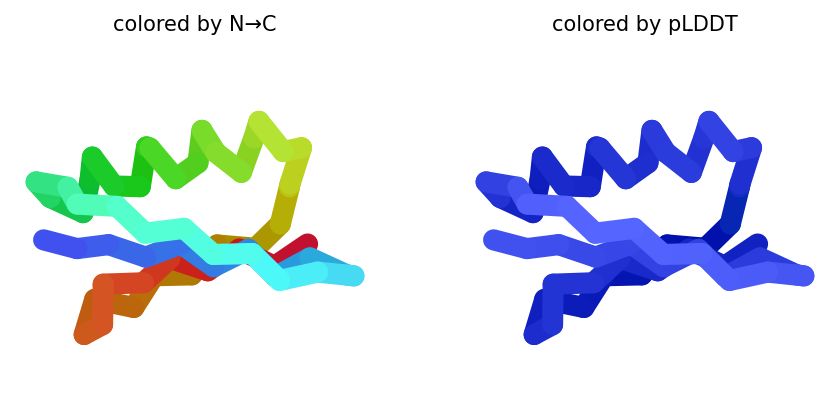

2024-07-02 09:25:38,853 reranking models by 'plddt' metric
2024-07-02 09:25:38,854 rank_001_alphafold2_ptm_model_5_seed_000 pLDDT=95.1 pTM=0.752
2024-07-02 09:25:38,854 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=74.4 pTM=0.552
2024-07-02 09:25:38,855 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=64.6 pTM=0.408
2024-07-02 09:25:38,856 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=61.1 pTM=0.374
2024-07-02 09:25:38,856 rank_005_alphafold2_ptm_model_3_seed_000 pLDDT=60.9 pTM=0.364
2024-07-02 09:25:40,241 Done
Time taken for extracting and saving feature.pkl: 172.22927498817444 seconds


0

In [6]:
# Import the time module
import time

#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  # Save input features to feature.pkl
  feature_path = os.path.join(jobname, "feature.pkl")
  with open(feature_path, 'wb') as f:
    pickle.dump(input_features, f)

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))

# Add timing code around the feature extraction process
start_time2 = time.time()
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,  # Add input features callback
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
end_time2 = time.time()
print(f"Time taken for extracting and saving feature.pkl: {end_time2 - start_time2} seconds")

results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

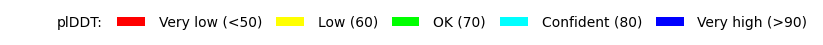

In [7]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [8]:
#@title Package and download results
if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
end_time = time.time()
print(f"Total time taken: {end_time - start_time} seconds")

Total time taken: 335.15998458862305 seconds
